<a href="https://colab.research.google.com/github/btiv/stock-trend-prediction/blob/master/Price_Trend_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2020 Brendan Tivnan
#
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# NOTICE: THIS FILE HAS BEEN MODIFIED BY Brendan Tivnan UNDER COMPLIANCE 
# WITH THE APACHE 2.0 LICENCE FROM THE ORIGINAL WORK OF THE COMPANY 
# Google LLC.

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns


the label will be the delta between the close and open price, a positive delta indicates an increase of price, a negative indicates a decrease. The features
will be volume, stochastic oscillator, relative strength index and the 
aroon indicator

In [5]:
# data collection


# get the price data for a given stock, IBM default

price_data = pd.read_csv("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&apikey=ZRNIEDRNCDG5D4TZ&datatype=csv")

# compute the delta

price_data["delta"] = price_data["close"] - price_data["open"]

# scale volume

price_data["volume"] = price_data["volume"] / 100000

# collect other feature data

stoch_data = pd.read_csv("https://www.alphavantage.co/query?function=STOCH&symbol=IBM&interval=daily&apikey=ZRNIEDRNCDG5D4TZ&datatype=csv")
rsi_data = pd.read_csv("https://www.alphavantage.co/query?function=RSI&symbol=IBM&interval=daily&time_period=10&series_type=open&apikey=ZRNIEDRNCDG5D4TZ&datatype=csv")
aroon_data = pd.read_csv("https://www.alphavantage.co/query?function=AROON&symbol=IBM&interval=daily&time_period=14&apikey=ZRNIEDRNCDG5D4TZ&datatype=csv")

In [6]:
# drop the first value to offset label and features
stoch_data = stoch_data.iloc[1:]
rsi_data = rsi_data.iloc[1:]
aroon_data = aroon_data.iloc[1:]

# add feature data to price data frame

price_data["SlowD"] = stoch_data["SlowD"]
price_data["SlowK"] = stoch_data["SlowK"]
price_data["RSI"] = rsi_data["RSI"]
price_data["AroonDown"] = aroon_data["Aroon Down"]
price_data["AroonUp"] = aroon_data["Aroon Up"]

# shift data up

price_data["SlowD"] = price_data["SlowD"].shift(-1)
price_data["SlowK"] = price_data["SlowK"].shift(-1)
price_data["RSI"] = price_data["RSI"].shift(-1)
price_data["AroonDown"] = price_data["AroonDown"].shift(-1)
price_data["AroonUp"] = price_data["AroonUp"].shift(-1)

# delete rows with empty cells

price_data.dropna(subset=["SlowD", "SlowK", "RSI", "AroonDown", "AroonUp"], inplace=True)

#shuffle the examples and then split into training and test sets

price_data = price_data.reindex(np.random.permutation(price_data.index))

train_df = price_data.iloc[:4229, :]
test_df = price_data.iloc[4229:5000, :]
validation_df = price_data.iloc[5000:, :]

print(train_df)

       timestamp    open    high  ...      RSI  AroonDown   AroonUp
5107  2000-05-17  107.50  108.87  ...  41.9652    92.8571    0.0000
2252  2011-09-22  168.33  169.97  ...  62.4767    50.0000  100.0000
3684  2006-01-17   82.80   83.16  ...  45.7080    42.8571   64.2857
4464  2002-12-10   78.60   81.00  ...  44.9391     7.1429   64.2857
1998  2012-09-25  205.60  207.32  ...  58.8304     0.0000   64.2857
...          ...     ...     ...  ...      ...        ...       ...
3248  2007-10-10  118.00  118.80  ...  57.2595    78.5714   64.2857
2202  2011-12-02  189.92  191.33  ...  58.5314    71.4286  100.0000
883   2017-03-03  180.04  181.32  ...  63.1150     0.0000   35.7143
2748  2009-10-05  118.90  120.18  ...  37.7586     0.0000   28.5714
2174  2012-01-13  179.48  179.61  ...  39.1129   100.0000   50.0000

[4229 rows x 12 columns]


In [7]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent volume.
volume = tf.feature_column.numeric_column("volume")
feature_columns.append(volume)

# Create a numerical feature column to represent SlowD.
slowd = tf.feature_column.numeric_column("SlowD")
feature_columns.append(slowd)

# Create a numerical feature column to represent SlowK.
slowk = tf.feature_column.numeric_column("SlowK")
feature_columns.append(slowk)

# Create a numerical feature column to represent RSI.
rsi = tf.feature_column.numeric_column("RSI")
feature_columns.append(rsi)

# Create a numerical feature column to represent Aroon Down.
aroon_down = tf.feature_column.numeric_column("AroonDown")
feature_columns.append(aroon_down)

# Create a numerical feature column to represent Aroon Up.
aroon_up = tf.feature_column.numeric_column("AroonUp")
feature_columns.append(aroon_up)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
my_feature_layer = layers.DenseFeatures(feature_columns)

In [8]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.95, rmse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [14]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 12 nodes.   
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 20 nodes. 
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.1), 
                                  name='Hidden2'))
  
  # Define the third hidden layer with 64 nodes. 
  model.add(tf.keras.layers.Dense(units=64, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.2), 
                                  name='Hidden3'))
  
  # Define the fourth hidden layer with 64 nodes. 
  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.3), 
                                  name='Hidden4'))

  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

In [15]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse

Epoch 1/500
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
43/43 [==============================] - 0s 2ms/step - loss: 32.6358 - root_mean_squared_error: 1.7352
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 19.5687 - root_mean_squared_error: 1.5581
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 13.4261 - root_mean_squared_error: 1.5666
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 10.3251 - root_mean_squared_error: 1.5813
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 8.4885 - root_mean_squared_error: 1.5675
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 7.2826 - root_mean_squared_error: 1.5591
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 6.3929 - root_mean_squared_error: 1.5487
Epoch 8/500
43/43 [==============================] - 0s 2ms/step - loss: 5.7350 - root_m

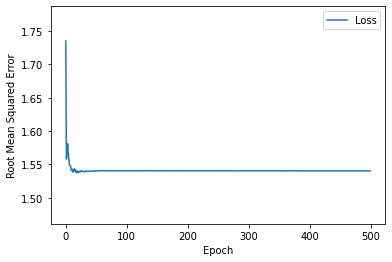


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
8/8 [==============================] - 0s 2ms/step - loss: 2.4531 - root_mean_squared_error: 1.5662


[2.453098773956299, 1.5662370920181274]

In [17]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 500
batch_size = 100
label_name = "delta"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, rmse = train_model(my_model, train_df, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, rmse)

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [13]:
# make a prediction and compare to true value

validation_features = {name:np.array(value) for name, value in validation_df.items()}

print(validation_features)

predictions = my_model.predict(validation_features)

print(predictions)

# model only doing all positive or all negative for all predictions

{'timestamp': array(['2019-04-25', '2000-09-27', '2016-05-24', '2002-02-26',
       '2005-04-04', '2018-08-14', '2002-11-22', '2014-09-12',
       '2009-04-24', '2008-06-03', '2012-10-05', '2011-10-05',
       '2013-06-07', '2006-03-28', '2001-01-23', '2000-08-22',
       '2019-01-15', '2001-01-10', '2014-05-23', '2004-07-02',
       '2013-10-29', '2016-10-27', '2020-01-13', '2017-06-21',
       '2005-11-14', '2015-11-12', '2003-11-26', '2014-08-01',
       '2009-11-18', '2009-08-06', '2002-02-04', '2001-04-25',
       '2006-10-31', '2003-10-03', '2001-08-23', '2009-03-06',
       '2016-01-27', '2003-09-24', '2005-02-18', '2014-11-05',
       '2001-04-03', '2001-07-19', '2012-11-26', '2005-03-28',
       '2005-03-08', '2012-03-13', '2016-02-10', '2000-07-25',
       '2005-03-31', '2003-10-02', '2006-12-07', '2002-04-16',
       '2016-11-07', '2013-08-21', '2000-03-17', '2005-02-08',
       '2019-04-12', '2003-08-27', '2000-03-08', '2006-09-28',
       '2019-07-11', '2000-01-27', '2006-